In [1]:
from torch.utils.tensorboard import SummaryWriter

In [2]:
from __future__ import annotations
import os
import datetime
import numpy as np
import sklearn.metrics
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader, WeightedRandomSampler
import sklearn.datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18


from tqdm.notebook import tqdm
import seaborn as sns

sns.set_style("dark")
sns.set(rc={"figure.figsize": (10, 10), "axes.grid": False})

In [3]:
from torch.utils.data.dataloader import default_collate

In [4]:
rng = np.random.default_rng()

In [5]:
label_description = [
     'A',   'I',   'U',  'E',  'O',
    'KA',  'KI',  'KU', 'KE', 'KO',
    'SA', 'SHI',  'SU', 'SE', 'SO',
    'TA', 'CHI', 'TSU', 'TE', 'TO',
    'NA',  'NI',  'NU', 'NE', 'NO',
    'HA',  'HI',  'FU', 'HE', 'HO',
    'MA',  'MI',  'MU', 'ME', 'MO',
    'YA',         'YU',       'YO',
    'RA',  'RI',  'RU', 'RE', 'RO',
    'WA',  'II',        'EE', 'WO',
     'N',  'IT'
]

In [6]:
def plot_grid(X, y, ncols=2, nrows=2, figsize=(10, 10), hide_axes=True):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    indexes = rng.choice(np.arange(X.shape[0]), size=ax.shape)
    imgs = X[indexes].reshape(*ax.shape, 28, 28)
    labels = y[indexes].reshape(*ax.shape)
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].imshow(imgs[i, j], cmap='gray')
            ax[i, j].set_title(label_description[labels[i, j]])
            if hide_axes:
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)

In [7]:
def plot_grid_and_label(
    dataloader,
    model,
    ncols=2,
    nrows=2,
    figsize=(10, 10),
    hide_axes=True,
    flatten_image=True,
    label_description=None,
):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)

    batch = next(iter(dataloader))
    idx = rng.choice(np.arange(len(batch[0])), size=(nrows * ncols))

    imgs = batch[0][idx].to(device="cpu")
    labels = batch[1][idx].to(device="cpu")
    print(imgs.shape)
    pred = model(imgs).to(device="cpu")
    imgs, labels, pred = (
        imgs.to(device="cpu").reshape(nrows, ncols, 28, 28),
        labels.to(device="cpu").reshape(nrows, ncols, -1),
        pred.reshape(nrows, ncols, -1),
    )

    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].imshow(imgs[i, j], cmap="gray")
            ax[i, j].set_title(
                f"label: {label_description[labels[i, j].argmax()]}, prediction: {label_description[pred[i, j].argmax()]}"
            )
            if hide_axes:
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)

In [8]:
X, y = sklearn.datasets.fetch_openml('Kuzushiji-49', version=1, return_X_y=True, as_frame=False, parser='auto')
X = X.reshape((-1, 28, 28))
y = np.array(list(map(int, y)))
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [9]:
counts = { j: np.sum(y_train == i) for i, j in enumerate(label_description) }

In [10]:
counts # what to do with imbalanced classes?

{'A': 5241,
 'I': 5253,
 'U': 5205,
 'E': 656,
 'O': 5291,
 'KA': 5236,
 'KI': 5303,
 'KU': 5235,
 'KE': 4129,
 'KO': 5222,
 'SA': 5192,
 'SHI': 5277,
 'SU': 5256,
 'SE': 3662,
 'SO': 3347,
 'TA': 5288,
 'CHI': 2259,
 'TSU': 5288,
 'TE': 5287,
 'TO': 5196,
 'NA': 5250,
 'NI': 5215,
 'NU': 1816,
 'NE': 2168,
 'NO': 5231,
 'HA': 5255,
 'HI': 4475,
 'FU': 5226,
 'HE': 5222,
 'HO': 1769,
 'MA': 5285,
 'MI': 2664,
 'MU': 1492,
 'ME': 2958,
 'MO': 5229,
 'YA': 5190,
 'YU': 1403,
 'YO': 5250,
 'RA': 5282,
 'RI': 5257,
 'RU': 5271,
 'RE': 5240,
 'RO': 1849,
 'WA': 2102,
 'II': 364,
 'EE': 325,
 'WO': 5231,
 'N': 5262,
 'IT': 3080}

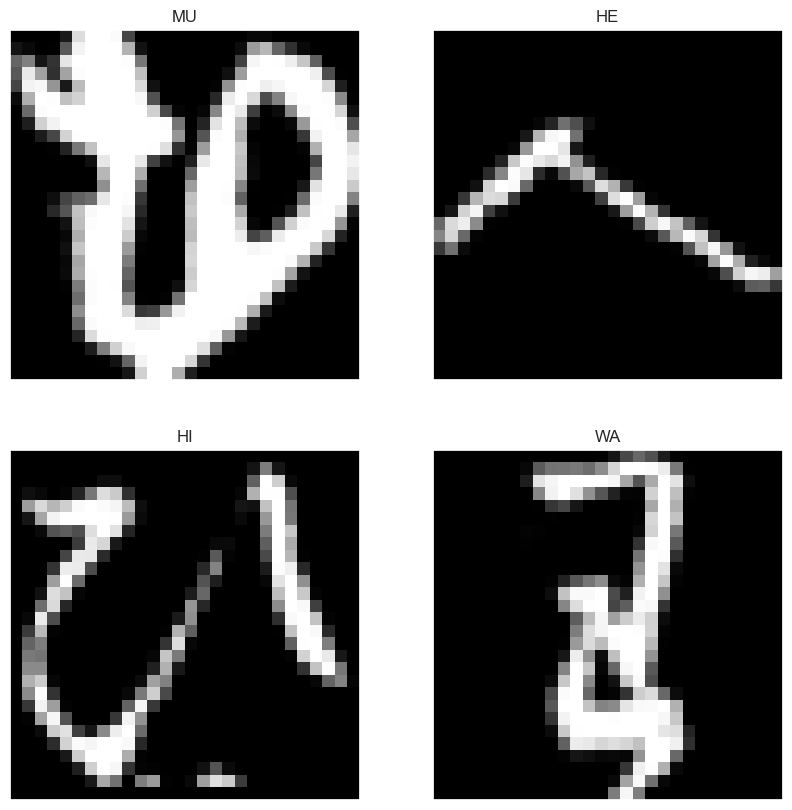

In [11]:
plot_grid(X_train, y_train)

## Torch utils

In [12]:
def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn * s
        pp += nn
    return pp

In [13]:
class FlattenDataset(Dataset):
    inds = torch.arange(49)

    def __init__(self, images, targets, transform=None, target_transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = (FlattenDataset.inds == self.targets[idx]).to(dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


class ImageDataset(Dataset):
    inds = torch.arange(49, device='cuda')

    def __init__(self, images, targets, transform=None, target_transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = (ImageDataset.inds == self.targets[idx]).to(dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [14]:
def accuracy_func(pred, tareget):
    return (pred.argmax(dim=-1) == tareget.argmax(dim=-1)).sum() / len(tareget)


def train_one_epoch(
    model: torch.nn.Module,
    loss_fn,
    epoch_index,
    training_loader,
    testing_loader,
    optimizer,
    writer: SummaryWriter,
    model_name,
    smalest_test_loss=np.inf,
):
    running_loss = 0.0
    running_acc = 0.0
    last_loss = 0.0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    with tqdm(training_loader) as iterator:
        for i, data in enumerate(iterator):
            model.train(True)
            # Every data instance is an input + label pair
            inputs, labels = data

            # Zero your gradients for every batch!
            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs)

            # Compute the loss and its gradients
            loss = loss_fn(outputs, labels)
            loss.backward()

            # Adjust learning weights
            optimizer.step()

            # Gather data and report
            running_loss += loss
            running_acc += accuracy_func(outputs, labels)
            if i % 200 == 199:
                running_loss_test = 0
                running_acc_test = 0

                last_loss = running_loss / 200  # loss per batch
                tb_x = epoch_index * len(training_loader) + i + 1

                iterator.set_description_str(str(running_acc / 200))
                writer.add_scalars(
                    "accuracy",
                    {
                        "train": running_acc / 200,
                    },
                    tb_x,
                )
                writer.add_scalars(
                    "loss",
                    {
                        "train": running_loss / 200,
                    },
                    tb_x,
                )
                running_loss = 0.0
                running_acc = 0.0
        del loss
        torch.cuda.empty_cache()
    return last_loss, smalest_test_loss

## Flattened images
Use Dense layers

In [15]:
# create train and validation datasets, these datasets should use flattened images
train_ds = FlattenDataset(
    X_train,
    y_train,
    transform=T.Lambda(lambda x: torch.flatten(torch.tensor(x, dtype=torch.float32))),
)

test_ds = FlattenDataset(
    X_test,
    y_test,
    transform=T.Lambda(lambda x: torch.flatten(torch.tensor(x, dtype=torch.float32))),
)

In [16]:
values, counts = np.unique(y_train, return_counts=True)
counts = 1/counts[np.argsort(values)]
weights = np.apply_along_axis(lambda x: counts[x], arr=y_train, axis=0)

In [17]:
train_dl = DataLoader(
    train_ds,
    batch_size=256,
    sampler=WeightedRandomSampler(weights, len(weights), ),
    collate_fn=lambda x: tuple(x_.to('cuda') for x_ in default_collate(x)),
)

test_dl = DataLoader(
    test_ds,
    shuffle=True,
    batch_size=256,
    collate_fn=lambda x: tuple(x_.to('cuda') for x_ in default_collate(x))
)

In [18]:
# create model, this model should accept a flattened image


class DenseModel(torch.nn.Module):
    def __init__(self, device="cpu"):
        super(DenseModel, self).__init__()
        self.layers = torch.nn.ModuleList(
            [
                torch.nn.Linear(784, 256),
                torch.nn.BatchNorm1d(256),
                torch.nn.LeakyReLU(),

                torch.nn.Linear(256, 256),
                torch.nn.BatchNorm1d(256),
                torch.nn.LeakyReLU(),

                torch.nn.Linear(256, 128),
                torch.nn.BatchNorm1d(128),
                torch.nn.LeakyReLU(),

                torch.nn.Linear(128, 128),
                torch.nn.BatchNorm1d(128),
                torch.nn.LeakyReLU(),

                torch.nn.Linear(128, 128),
                torch.nn.BatchNorm1d(128),
                torch.nn.LeakyReLU(),

                torch.nn.Linear(128, 64),
                torch.nn.BatchNorm1d(64),
                torch.nn.LeakyReLU(),
                
                torch.nn.Linear(64, 49),
            ]
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


model = DenseModel(device="cuda").to(device="cuda")

In [19]:
logdir = os.path.join(
    "logs/kuzushiji-49/dense", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)
writer = SummaryWriter(log_dir=logdir)
writer.add_graph(model, next(iter(train_dl))[0])


In [20]:
# compile the model, make sure to add accuracy metric
loss = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(list(model.parameters()))

In [21]:
x, y = next(iter(train_dl))

In [22]:
pred = model(x)

In [23]:
params = list(model.parameters())

In [24]:
get_n_params(model)

346033

In [25]:
min_test = np.inf
for i in tqdm(range(10)):
    model.train(True)
    loss_val, min_test = train_one_epoch(
        model,
        loss,
        i,
        train_dl,
        test_dl,
        optim,
        writer,
        "DenseModel",
        min_test,
    )

    model.eval()

    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for data, label in test_dl:
            pred = model(data)
            running_loss += loss(pred, label).detach()
            running_acc += accuracy_func(pred, label)
        writer.add_scalars(
            "loss",
            {
                "test": running_loss / len(test_dl),
            },
            len(train_dl) * (i + 1),
        )
        writer.add_scalars(
            "accuracy",
            {
                "test": running_acc / len(test_dl),
            },
            len(train_dl) * (i + 1),
        )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

torch.Size([4, 784])


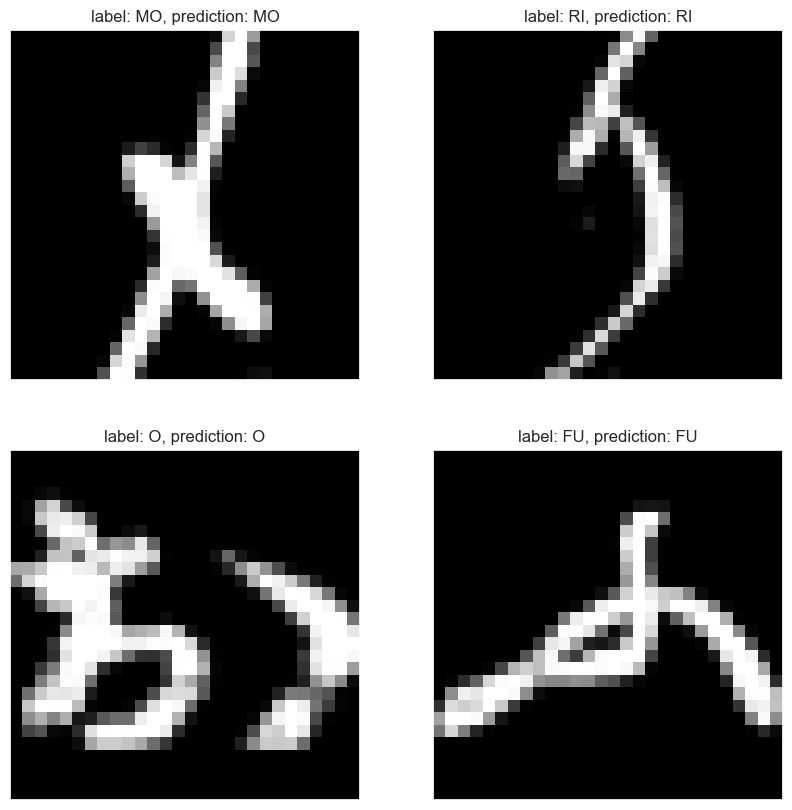

In [26]:
plot_grid_and_label(test_dl, model.to(device='cpu'), label_description=label_description)

In [27]:
y_pred = (
    model(torch.tensor(X_test).reshape(-1, 28 * 28).to(dtype=torch.float32))
    .detach()
    .numpy()
).argmax(axis=-1)

In [28]:
y_test

array([ 2,  4, 15, ...,  7,  8, 22])

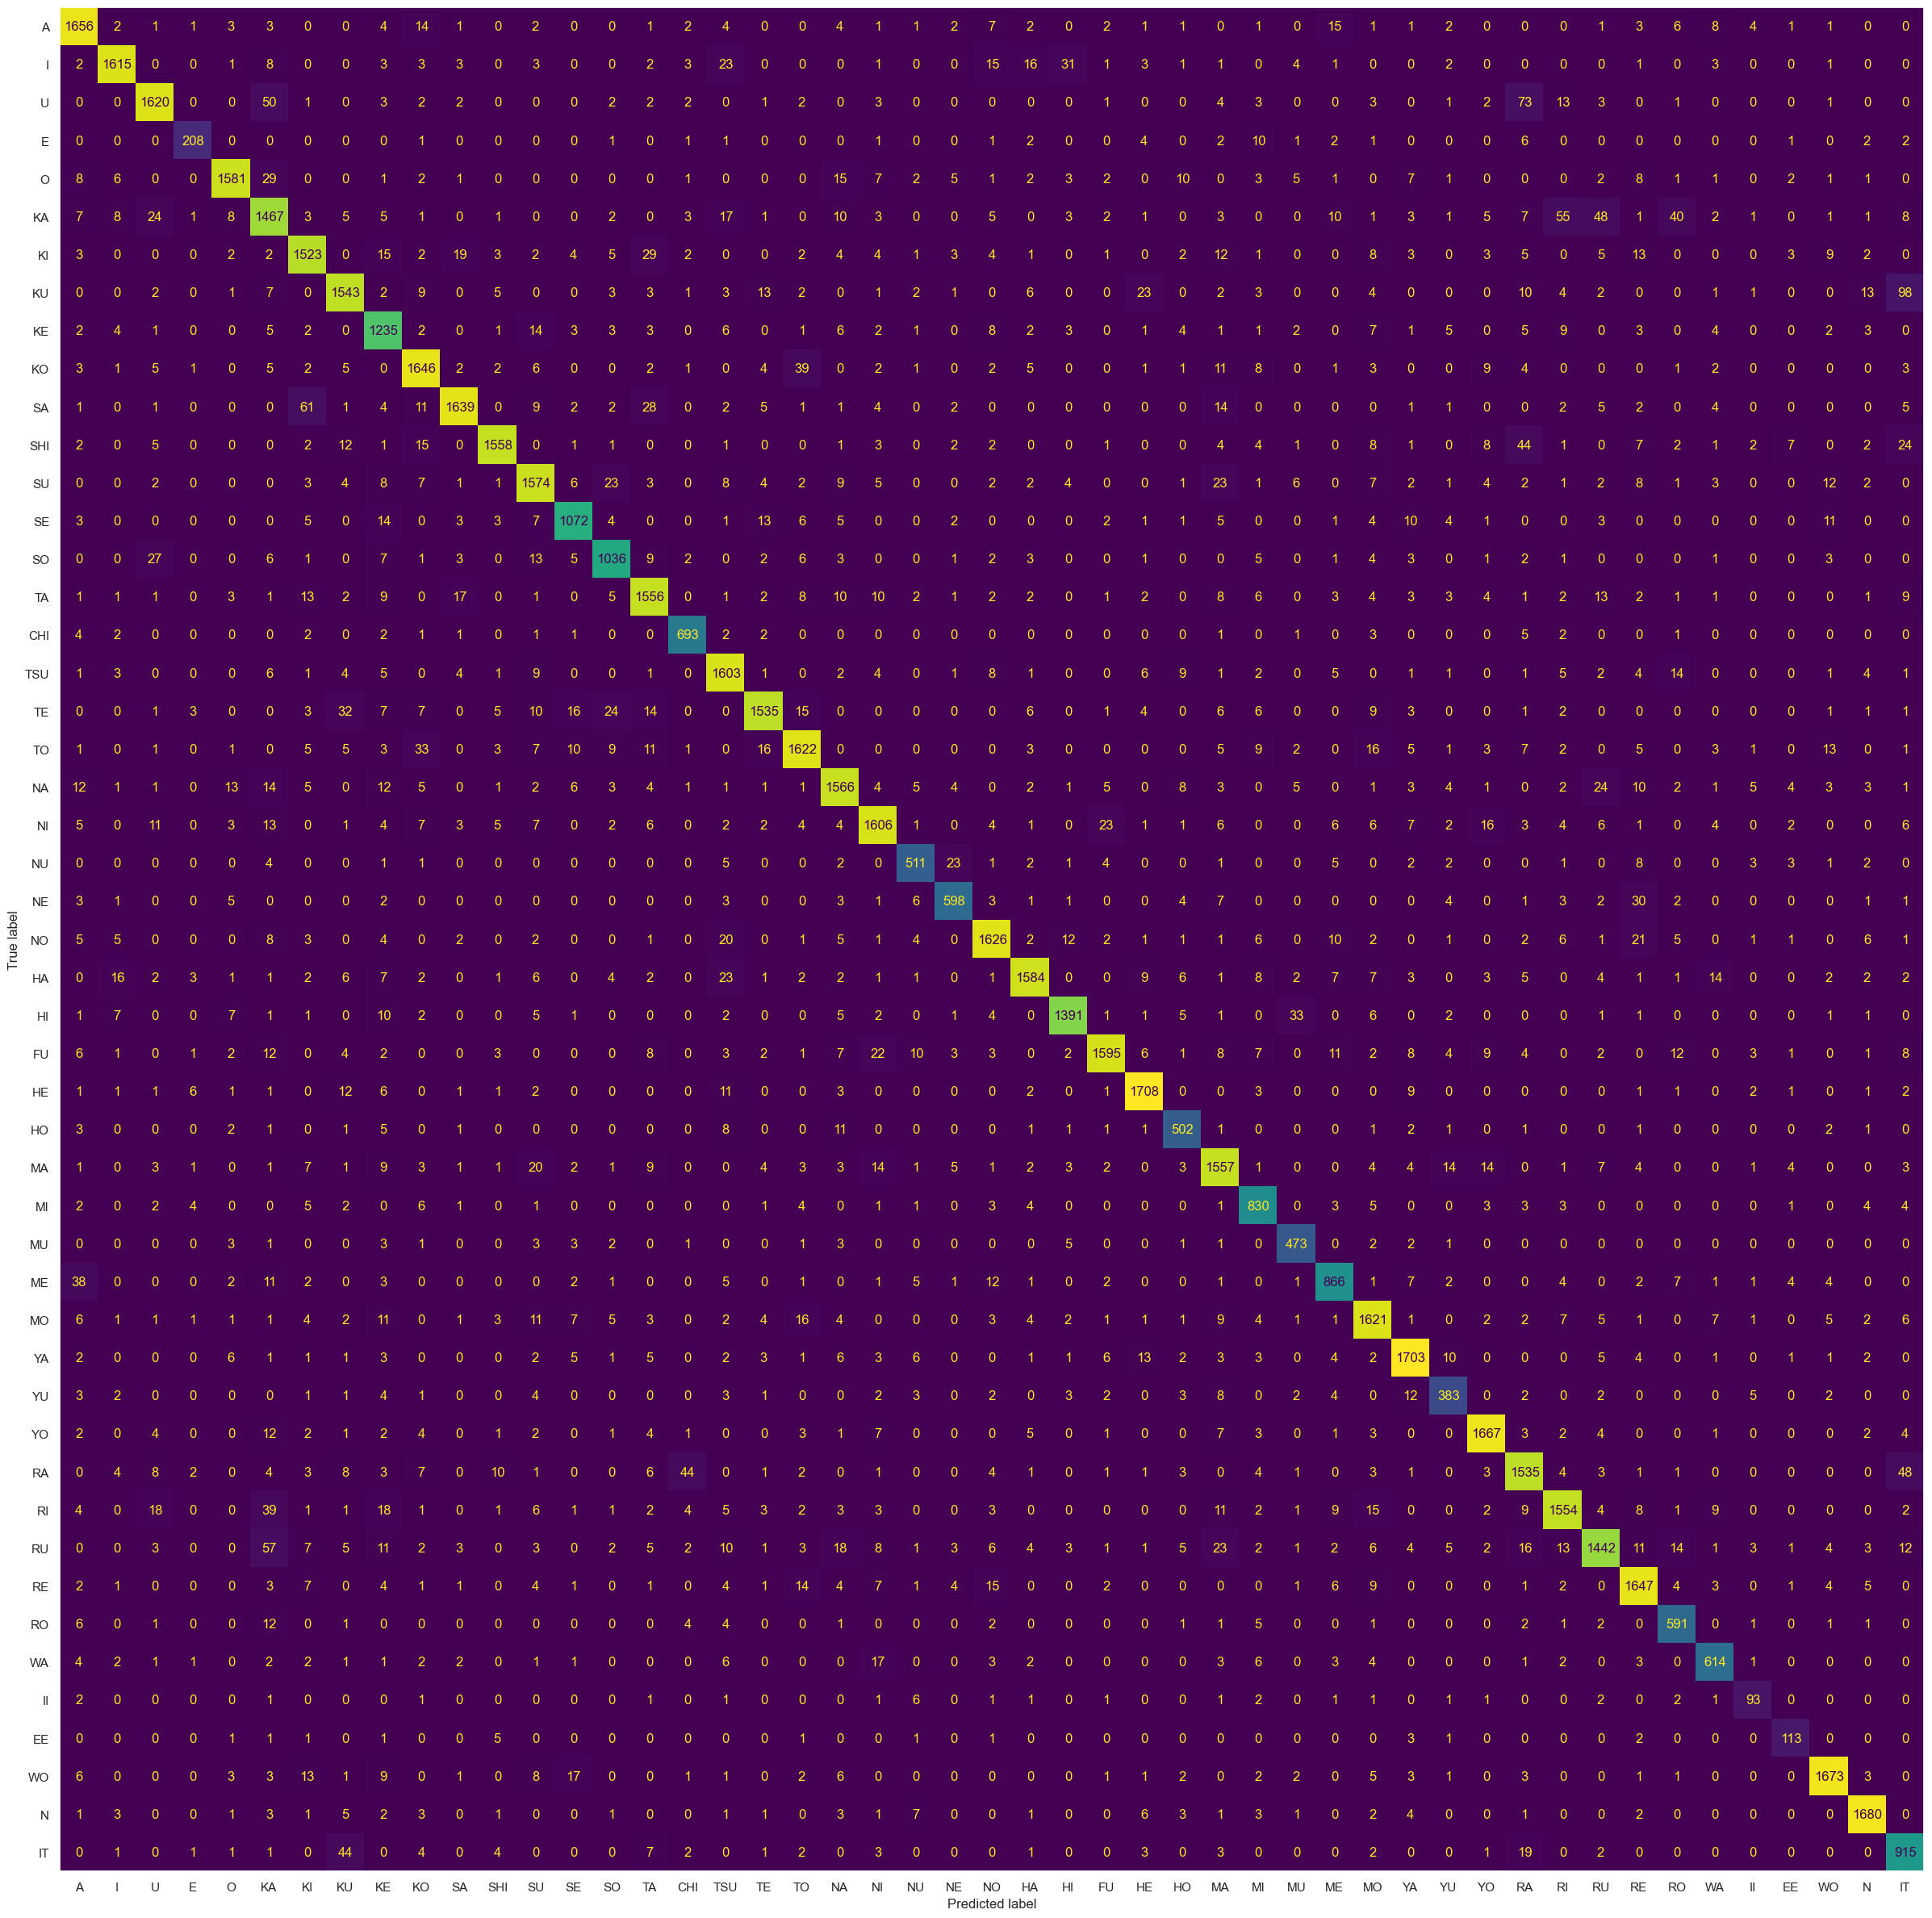

In [29]:
_, ax = plt.subplots(figsize=(30, 30))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_description, ax=ax, colorbar=False)

##### Balanced accuracy

In [30]:
accuracy = y_test == y_pred
accuracy.sum()/len(y_test), np.mean([np.mean(accuracy[y_test == i]) for i in range(49)])

(0.9099043231750532, 0.9040724042622321)

In [31]:
writer.close()

In [32]:
del model
del y_pred
del accuracy
del train_dl
del test_dl
del train_ds
del test_ds
del pred
del params
del optim

## Actual images
Use Conv2D layers with Dense layer on top

In [33]:
# create train and validation datasets, these datasets should use 28x28x1 images

# create train and validation datasets, these datasets should use flattened images
train_ds = ImageDataset(
    torch.tensor(X_train).to(device="cuda"),
    torch.tensor(y_train).to(device="cuda"),
    transform=T.Lambda(
        lambda x: x.reshape(1, 28, 28).to(dtype=torch.float32)
    ),
)

test_ds = ImageDataset(
    torch.tensor(X_test).to(device="cuda"),
    torch.tensor(y_test).to(device="cuda"),
    transform=T.Lambda(
        lambda x: x.reshape(1, 28, 28).to(dtype=torch.float32)
    ),
)

In [34]:
values, counts = np.unique(y_train, return_counts=True)
counts = 1/counts[np.argsort(values)]
weights = np.apply_along_axis(lambda x: counts[x], arr=y_train, axis=0)

In [35]:
train_dl = DataLoader(
    train_ds,
    batch_size=128,
    sampler=WeightedRandomSampler(weights, len(weights)),
)

test_dl = DataLoader(
    test_ds,
    shuffle=True,
    batch_size=128,
)

In [44]:
class ConvModel(torch.nn.Module):
    def __init__(self, device="cpu"):
        super(ConvModel, self).__init__()

        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            #
            torch.nn.MaxPool2d(2),
            #
            torch.nn.Conv2d(32, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            #
            torch.nn.MaxPool2d(2),
            #
            torch.nn.Conv2d(32, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, 3),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            #
            torch.nn.MaxPool2d(2),
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(128, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(32, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(16, 49),
        )
    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)


model = ConvModel(device="cuda").to(device="cuda")


In [45]:
model(next(iter(train_dl))[0]).shape

torch.Size([128, 49])

In [46]:
logdir = os.path.join(
    "logs/kuzushiji-49/conv", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)
writer = SummaryWriter(log_dir=logdir)
writer.add_graph(model, next(iter(train_dl))[0])


In [47]:
# compile the model, make sure to add accuracy metric
loss = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(list(model.parameters()))

In [48]:
x, y = next(iter(train_dl))

In [49]:
pred = model(x)

In [50]:
params = list(model.parameters())

In [51]:
get_n_params(model)

61649

In [52]:
min_test = np.inf
for i in tqdm(range(30)):
    model.train(True)
    loss_val, min_test = train_one_epoch(
        model.to(device="cuda"),
        loss,
        i,
        train_dl,
        test_dl,
        optim,
        writer,
        "ConvModel",
        min_test,
    )

    model.eval()

    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for data, label in test_dl:
            pred = model(data)
            running_loss += loss(pred, label).detach()
            running_acc += accuracy_func(pred, label)
        writer.add_scalars(
            "loss",
            {
                "test": running_loss / len(test_dl),
            },
            len(train_dl) * (i + 1),
        )
        writer.add_scalars(
            "accuracy",
            {
                "test": running_acc / len(test_dl),
            },
            len(train_dl) * (i + 1),
        )

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

In [53]:
# del train_dl
# del test_dl
# del model
# del optim

In [54]:
# model = ConvModel("cuda")
# model.load_state_dict(torch.load("best_ConvModel.pt"))
# model.eval()
# model.to(device="cuda")

torch.Size([4, 1, 28, 28])


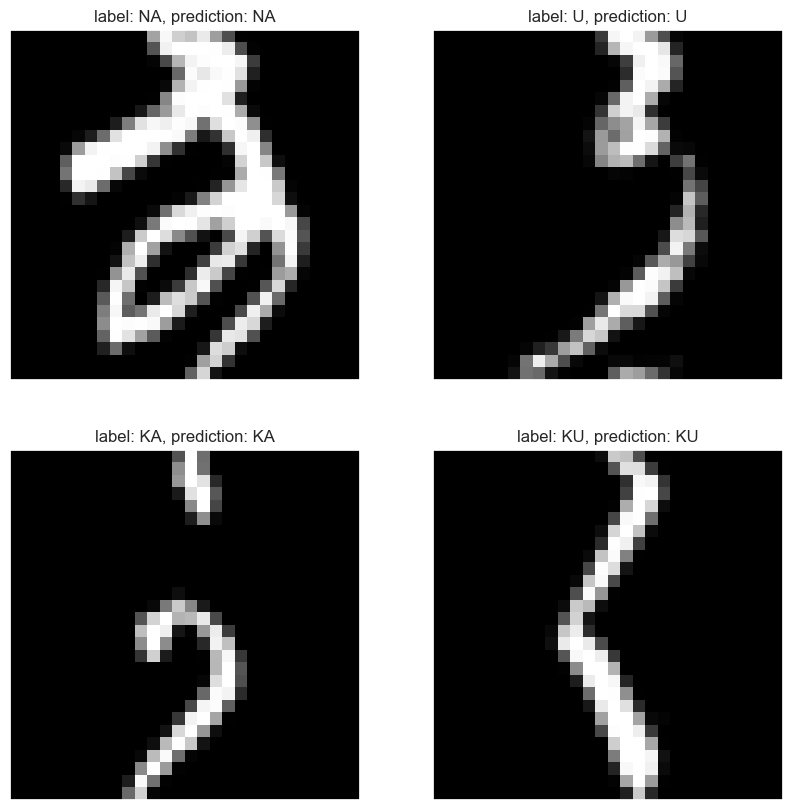

In [55]:
plot_grid_and_label(test_dl, model.to(device='cpu'), label_description=label_description)

In [56]:
len(X_test)

67728

In [57]:
model = model.eval()

ConvModel(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), paddi

In [58]:
with torch.no_grad():
    y_pred = (
        (
            model.to(device="cuda")(
                torch.tensor(X_test)
                .reshape(-1, 1, 28, 28)
                .to(device="cuda", dtype=torch.float32)
            )
            .detach()
            .cpu()
            .numpy()
        ).argmax(axis=-1)
    )


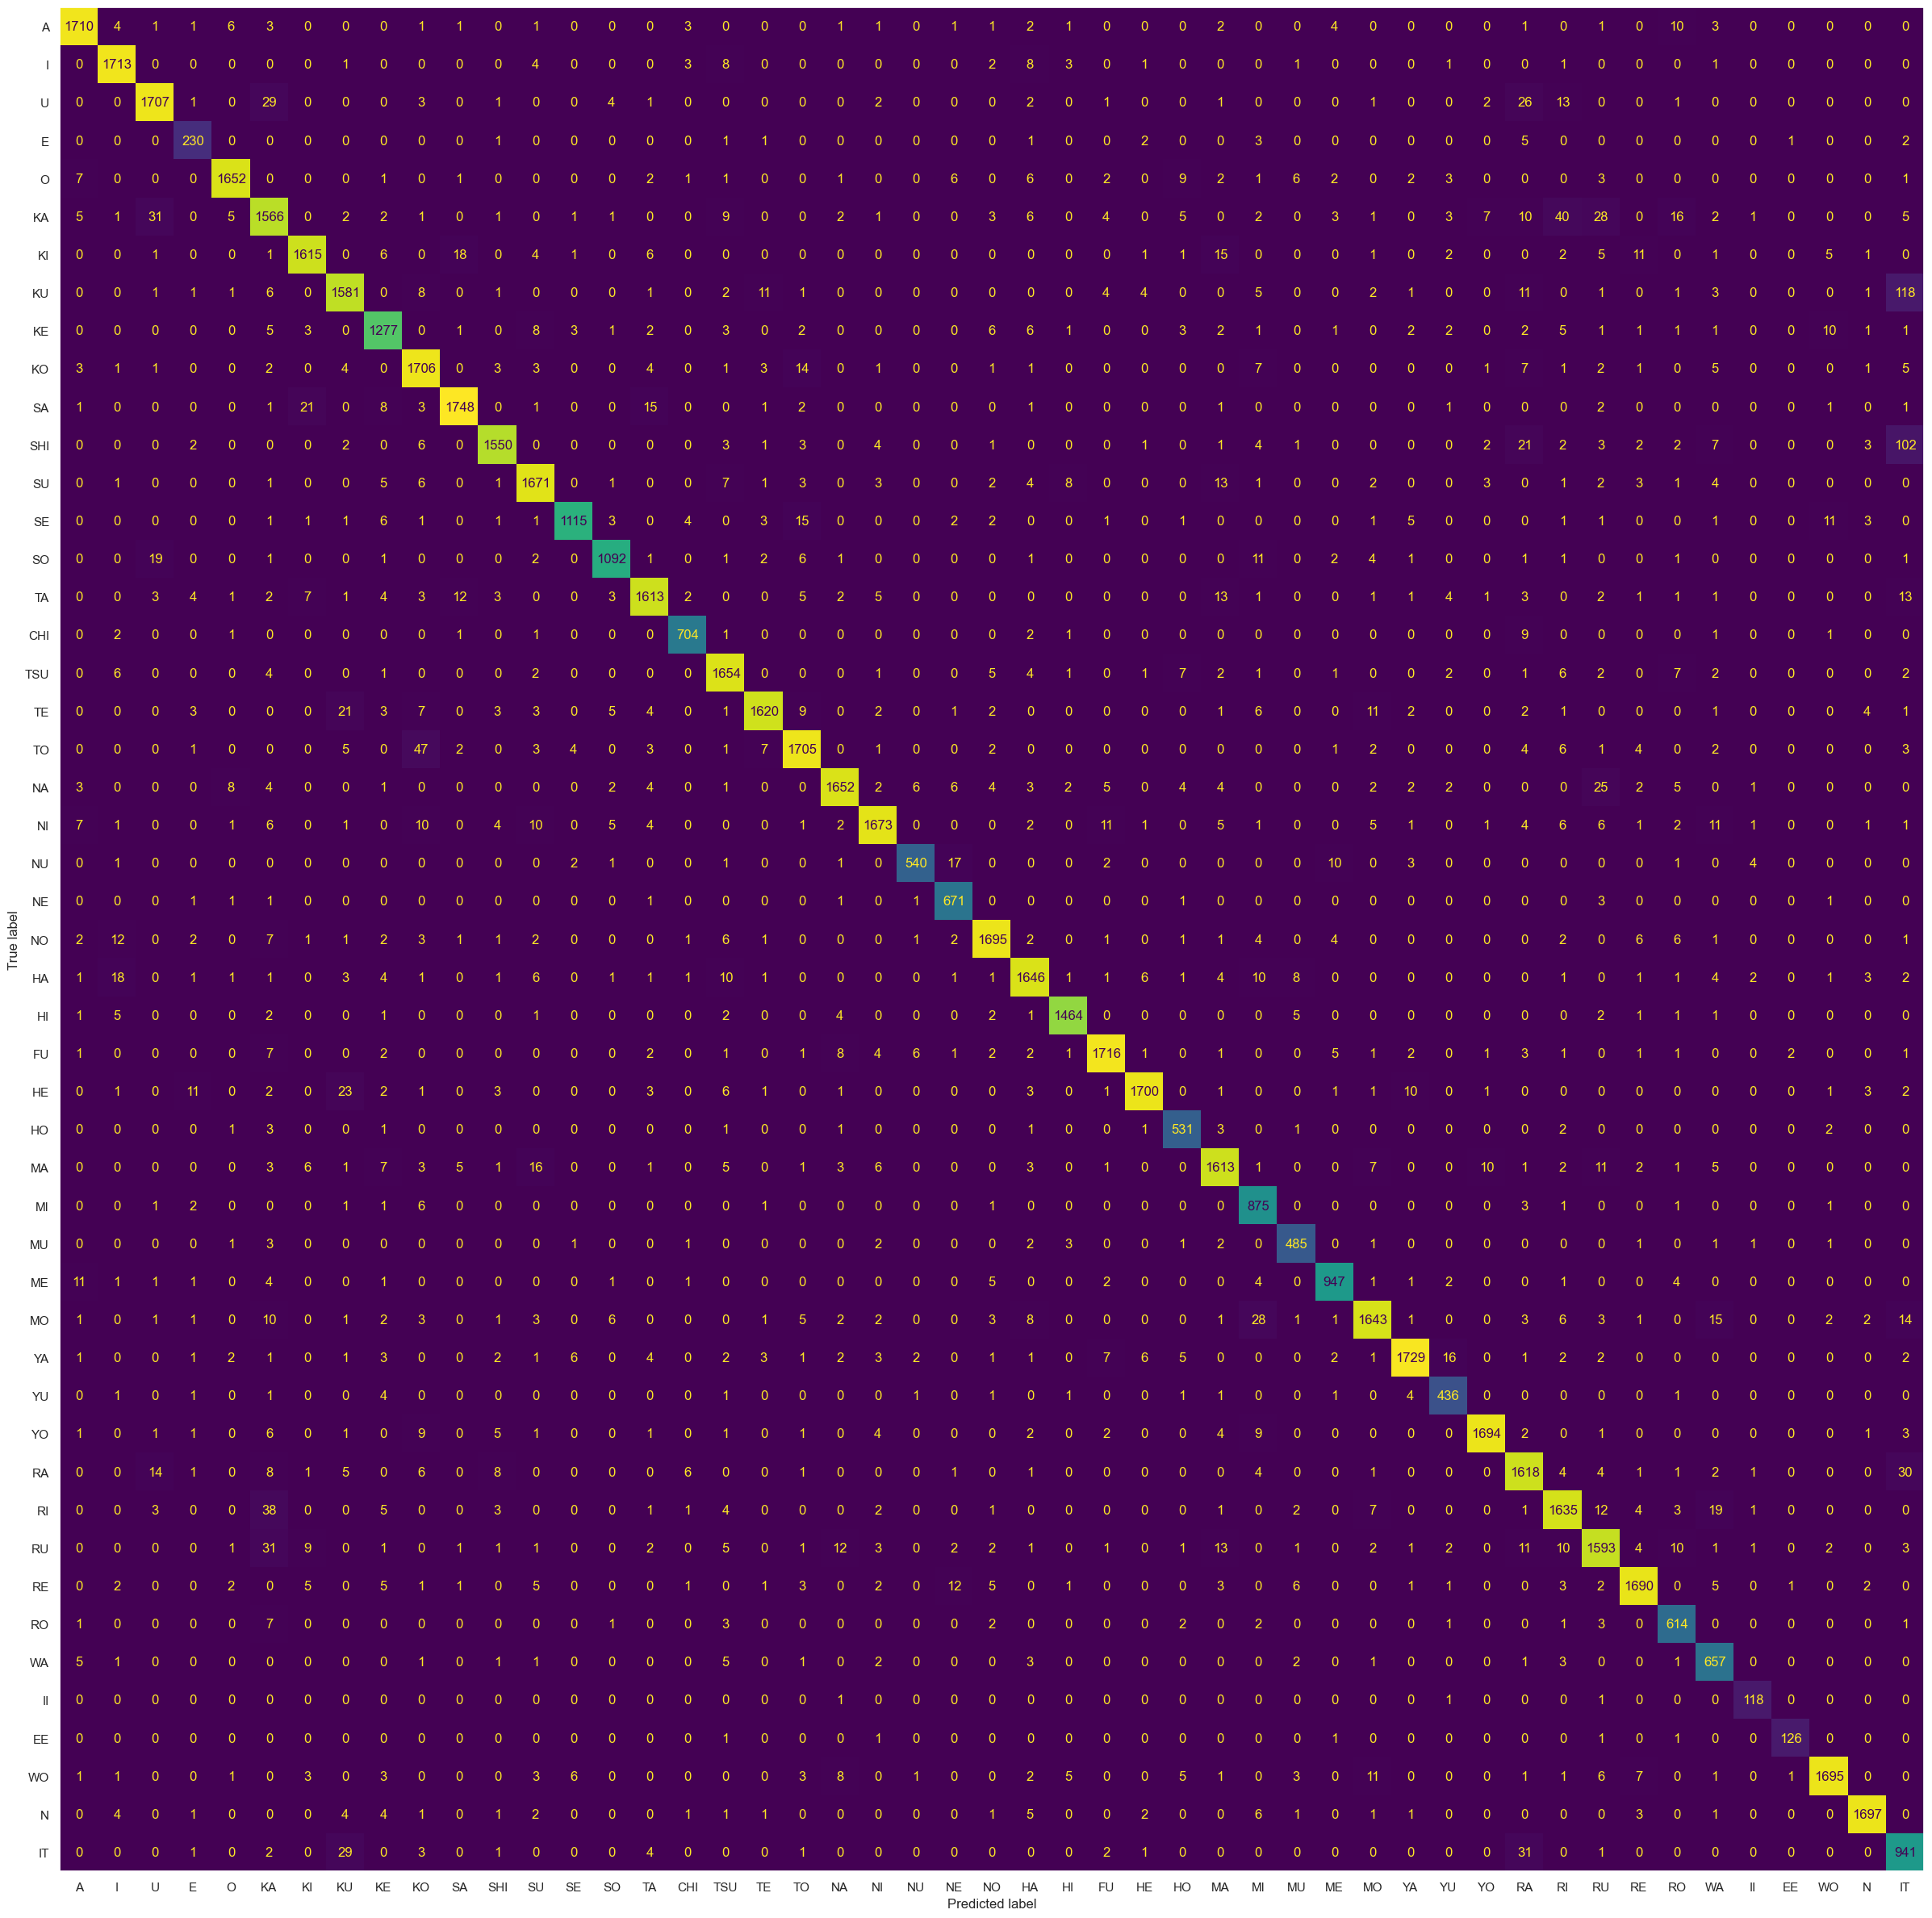

In [59]:
_, ax = plt.subplots(figsize=(30, 30))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_description, ax=ax, colorbar=False)

##### Balanced accuracy

In [60]:
accuracy = y_test == y_pred
accuracy.sum()/len(y_test), np.mean([np.mean(accuracy[y_test == i]) for i in range(49)])

(0.9497253720765415, 0.9514760710963781)

In [61]:
writer.close()